
--- Generating Scaling Law Plots (Train Samples) ---
🖼️ Saved plot: Sep_21/AllEnvs_ScalingLaw_TrainSamples.pdf

--- Generating Scaling Law Plots (Encode Dim) ---
🖼️ Saved plot: Sep_21/AllEnvs_ScalingLaw_EncodeDim.pdf

--- Generating Correlation Plot ---
🖼️ Saved correlation plot to Sep_21/error_vs_covariance_trend.pdf (with unified color scale)


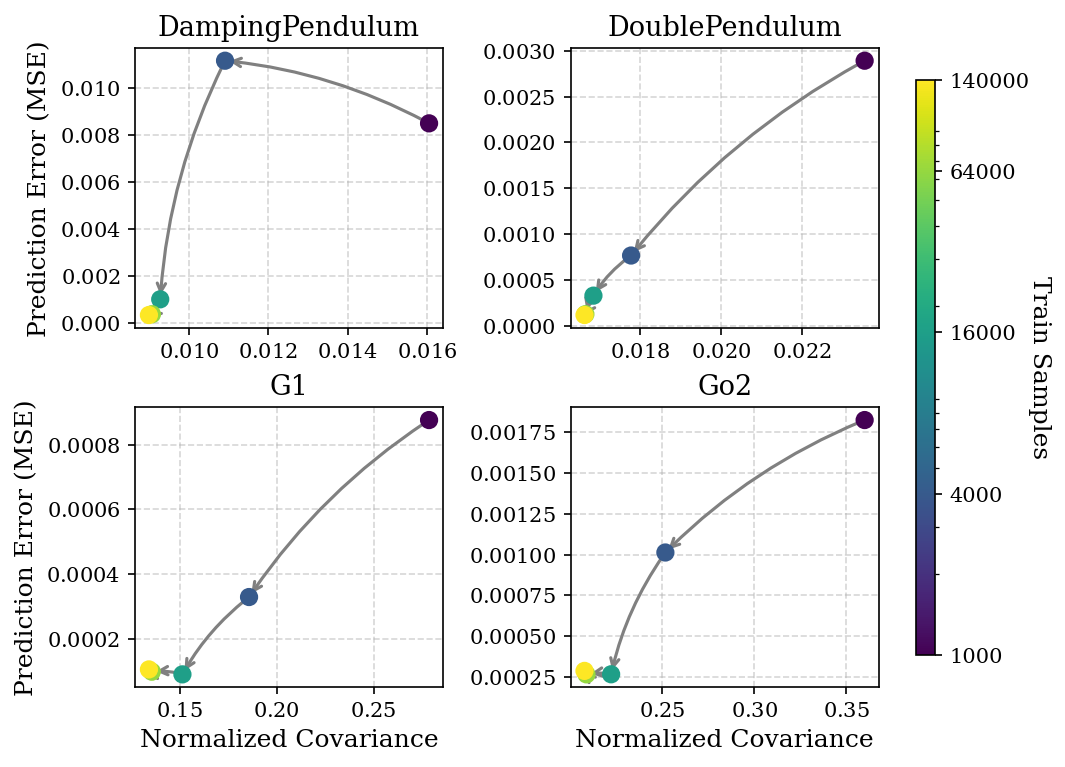

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D

# ============================
# Global Settings (For Full-Width/Bigger Plots)
# ============================
mpl.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "axes.titlesize": 9,
    "axes.labelsize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "legend.fontsize": 8,
    "lines.linewidth": 1.4,
    "lines.markersize": 5.5,
    "axes.formatter.use_mathtext": True,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "axes.prop_cycle": mpl.cycler(color=plt.cm.tab10.colors)
})

# ============================
# Configuration
# ============================
PROJECT_NAME = "Sep_21"

# Layout (2 rows x 3 cols):
# Col 1: DampingPendulum (top), DoublePendulum (bottom)
# Col 2: Franka (top), Kinova (bottom)
# Col 3: G1 (top), Go2 (bottom)
ENVS = ["DampingPendulum", "Franka", "G1",
        "DoublePendulum", "Kinova", "Go2"]

SEEDS            = [17382, 76849, 20965, 84902, 51194]
TRAIN_SAMPLES    = [1000, 4000, 16000, 64000, 140000]   # five curves in encode-dim plot
REL_MULT_TARGETS = [1, 2, 4, 8, 16]                      # five curves in train-sample plot
M_POLY = 100
U_DIM = {"Franka": 7, "DoublePendulum": 2, "DampingPendulum": 1, "G1": 23, "Go2": 12, "Kinova": 7}

# ============================
# Helpers & Data Loading
# ============================
def gmean(vals, eps: float = 1e-12) -> float:
    arr = np.asarray(list(vals), dtype=float)
    arr = np.maximum(arr, eps)
    return float(np.exp(np.mean(np.log(arr))))

def normalize_cov(row):
    learned_dim = row['encode_dim']
    if learned_dim <= 1:
        return row['test_CovLoss']
    return row['test_CovLoss'] / (learned_dim * (learned_dim - 1))

def env_has_control(env: str) -> bool:
    return U_DIM.get(env, 0) > 0

# --- Scaling Law Helpers ---
def scaling_model(D, A, alpha, C):
    return A * np.power(D, -alpha) + C

def scaling_model_log_fit(D, A, alpha, C):
    pred = A * np.power(D, -alpha) + C
    pred = np.maximum(pred, 1e-30)
    return np.log(pred)

def fit_scaling_law_log(D, E):
    D = np.asarray(D, dtype=float)
    E = np.asarray(E, dtype=float)
    mask = (D > 0) & (E > 0)
    D, E = D[mask], E[mask]
    if len(D) < 3:
        return None

    log_D = np.log(D)
    log_E = np.log(E)

    # Smart Init
    try:
        slope, intercept = np.polyfit(log_D, log_E, 1)
        alpha_init = -slope
        A_init = np.exp(intercept)
    except Exception:
        alpha_init = 1.0
        A_init = float(np.max(E))

    # Optimization
    try:
        popt, _ = curve_fit(
            scaling_model_log_fit,
            D,
            log_E,
            p0=[A_init, alpha_init, 0.0],
            bounds=([0.0, -np.inf, 0.0], [np.inf, np.inf, np.inf]),
            maxfev=20000
        )
        return popt
    except Exception as e:
        print(f"    ⚠️ Optimization failed: {e}")
        return None

# Label helpers
def format_train_samples(n: int) -> str:
    n = int(n)
    if n >= 1_000_000:
        return f"{n/1_000_000:.0f}M"
    if n >= 1_000:
        return f"{n/1_000:.0f}k"
    return str(n)

def format_mult(m: int) -> str:
    return f"n_multi={int(m)}"

# ============================
# Load Log
# ============================
log_csv = os.path.join("..", "log", "Sep_21", "koopman_results_log.csv")
if not os.path.exists(log_csv):
    print("⚠️ Log not found. Using dummy data structure.")
    log = pd.DataFrame()
else:
    log = pd.read_csv(log_csv)

# ============================
# Filter
# ============================
if not log.empty:
    mask = (
        log['env_name'].isin(ENVS) &
        log['seed'].isin(SEEDS) &
        log['train_samples'].isin(TRAIN_SAMPLES) &
        log['encode_dim_param'].isin(REL_MULT_TARGETS) &
        ((log['env_name'] != 'Polynomial') | (log['m'] == M_POLY))
    )
    filtered_log = log[mask].copy()
    filtered_log['z_dim'] = filtered_log['encode_dim'] + filtered_log['state_dim']
else:
    filtered_log = pd.DataFrame()

os.makedirs(PROJECT_NAME, exist_ok=True)

# ============================
# Shared color scale (like coeff plot: viridis, avoid endpoints)
# ============================
# Train-sample curves (for Encode-Dim scaling plot)
ts_list = sorted([int(x) for x in TRAIN_SAMPLES])
ts_vals = np.linspace(0.05, 0.95, len(ts_list))
ts_cmap = plt.cm.viridis
train_samples_to_color = {ts: ts_cmap(v) for ts, v in zip(ts_list, ts_vals)}

# Encode-mult curves (for Train-Sample scaling plot)
m_list = sorted([int(x) for x in REL_MULT_TARGETS])
m_vals = np.linspace(0.05, 0.95, len(m_list))
m_cmap = plt.cm.viridis
mult_to_color = {m: m_cmap(v) for m, v in zip(m_list, m_vals)}

# ============================
# 1) Scaling Law Plots (Train Samples): plot all 5 curves (one per EncodeDimMultiplier)
# ============================
print("\n--- Generating Scaling Law Plots (Train Samples) ---")
fig_ts, axes_ts = plt.subplots(2, 3, figsize=(12, 7), sharey=False)
axes_ts = axes_ts.flatten()

for i, env in enumerate(ENVS):
    ax = axes_ts[i]
    sub_df = filtered_log[(filtered_log.env_name == env) & (filtered_log.use_covariance_loss == 1)].copy()
    if env_has_control(env) and "use_control_loss" in filtered_log.columns:
        sub_df = sub_df[sub_df.use_control_loss == 1]

    ax.set_title(f"{env}")
    if sub_df.empty:
        continue

    # dot-only legend handles (like coeff plot)
    legend_handles = []

    for m in m_list:
        m_df = sub_df[sub_df["encode_dim_param"] == m].copy()
        if m_df.empty:
            continue

        # Use all seeds as dots
        D = m_df["train_samples"].astype(float).to_numpy()
        E = m_df["test_Kloss"].astype(float).to_numpy()
        color = mult_to_color[m]

        ax.plot(D, E, "o", color=color, alpha=0.35, label="_nolegend_", markeredgewidth=0.0)

        # Fit per curve (dashed, no legend entry)
        popt = None
        if len(D) >= 3:
            if env == "Franka":
                # keep your special-case fit for Franka
                try:
                    popt, _ = curve_fit(
                        scaling_model, D, E,
                        p0=[E.max(), 0.5, E.min()],
                        bounds=([0.0, 0.0, 0.0], [np.inf, 4.0, np.inf]),
                        maxfev=20000
                    )
                except Exception as ex:
                    print(f"⚠️ Old fit failed for Franka (m={m}): {ex}")
                    popt = None
            else:
                popt = fit_scaling_law_log(D, E)

        if popt is not None:
            A_hat, alpha_hat, C_hat = popt
            D_pos = D[D > 0]
            if D_pos.size > 1:
                D_fit = np.geomspace(D_pos.min(), D_pos.max(), 200)
                E_fit = scaling_model(D_fit, *popt)
                ax.plot(D_fit, E_fit, linestyle="-", linewidth=2.0, color=color, label="_nolegend_")

            legend_handles.append(
                Line2D([0], [0], marker="o", linestyle="None",
                       markersize=6.0, markerfacecolor=color, markeredgecolor=color,
                       label=f"{format_mult(m)}: $\\alpha={alpha_hat:.2f}$")
            )
        else:
            legend_handles.append(
                Line2D([0], [0], marker="o", linestyle="None",
                       markersize=6.0, markerfacecolor=color, markeredgecolor=color,
                       label=f"{format_mult(m)}")
            )

    row, col = divmod(i, 3)
    if col == 0:
        ax.set_ylabel("Prediction Error (MSE)")
    if row == 1:
        ax.set_xlabel("Training Samples")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True, which="both", ls="--", alpha=0.6)

    if legend_handles:
        ax.legend(handles=legend_handles, loc="upper right", frameon=True)

plot_path_ts = os.path.join(PROJECT_NAME, "AllEnvs_ScalingLaw_TrainSamples.pdf")
fig_ts.savefig(plot_path_ts, dpi=300)
plt.close(fig_ts)
print(f"🖼️ Saved plot: {plot_path_ts}")

# ============================
# 2) Scaling Law Plots (Encode Dim): plot all 5 curves (one per TrainSamples)
# ============================
print("\n--- Generating Scaling Law Plots (Encode Dim) ---")
fig_ed, axes_ed = plt.subplots(2, 3, figsize=(12, 7), sharey=False)
axes_ed = axes_ed.flatten()

for i, env in enumerate(ENVS):
    ax = axes_ed[i]
    sub_df = filtered_log[(filtered_log.env_name == env) & (filtered_log.use_covariance_loss == 1)].copy()
    if env_has_control(env) and "use_control_loss" in filtered_log.columns:
        sub_df = sub_df[sub_df.use_control_loss == 1]

    ax.set_title(f"{env}")
    if sub_df.empty:
        continue

    legend_handles = []

    for ts in ts_list:
        ts_df = sub_df[sub_df["train_samples"] == ts].copy()
        if ts_df.empty:
            continue

        D = ts_df["z_dim"].astype(float).to_numpy()
        E = ts_df["test_Kloss"].astype(float).to_numpy()
        color = train_samples_to_color[ts]

        # dots (no legend entry)
        ax.plot(D, E, "o", color=color, alpha=0.35, label="_nolegend_", markeredgewidth=0.0)

        # fit per curve (dashed)
        popt = None
        if len(D) >= 3:
            popt = fit_scaling_law_log(D, E)

        if popt is not None:
            A_hat, alpha_hat, C_hat = popt
            D_pos = D[D > 0]
            if D_pos.size > 1:
                D_fit = np.geomspace(D_pos.min(), D_pos.max(), 200)
                E_fit = scaling_model(D_fit, *popt)
                ax.plot(D_fit, E_fit, linestyle="-", linewidth=2.0, color=color, label="_nolegend_")

            legend_handles.append(
                Line2D([0], [0], marker="o", linestyle="None",
                    markersize=6.0, markerfacecolor=color, markeredgecolor=color,
                    label=f"$m={format_train_samples(ts)}$: $\\alpha={alpha_hat:.2f}$")
            )
        else:
            legend_handles.append(
                Line2D([0], [0], marker="o", linestyle="None",
                       markersize=6.0, markerfacecolor=color, markeredgecolor=color,
                       label=f"{format_train_samples(ts)}")
            )

    row, col = divmod(i, 3)
    if col == 0:
        ax.set_ylabel("Prediction Error (MSE)")
    if row == 1:
        ax.set_xlabel("Encode Dimension")

    ax.set_xscale("log", base=2)
    ax.set_yscale("log")
    ax.grid(True, which="both", ls="--", alpha=0.6)

    if legend_handles:
        ax.legend(handles=legend_handles, loc="upper right", frameon=True)

plot_path_ed = os.path.join(PROJECT_NAME, "AllEnvs_ScalingLaw_EncodeDim.pdf")
fig_ed.savefig(plot_path_ed, dpi=300)
plt.close(fig_ed)
print(f"🖼️ Saved plot: {plot_path_ed}")


# ============================
# 3) Plotting Correlation (Targeting Single Column)
# ============================
print("\n--- Generating Correlation Plot ---")
# ============================
# Reconstruct aggregated DF for Correlation Plot (FIX)
# ============================

if filtered_log.empty:
    df = pd.DataFrame()
else:
    tmp = filtered_log.copy()

    # --- compute normalized covariance correctly ---
    tmp["NormalizedCovariance"] = tmp.apply(normalize_cov, axis=1)

    # --- aggregate over seeds (geometric mean) ---
    df = (
        tmp.groupby(
            ["env_name", "train_samples", "encode_dim_param",
             "use_covariance_loss", "use_control_loss"],
            dropna=False
        )
        .agg(
            PredictionError=("test_Kloss", gmean),
            NormalizedCovariance=("NormalizedCovariance", gmean),
        )
        .reset_index()
        .rename(columns={
            "env_name": "Environment",
            "train_samples": "TrainSamples",
            "encode_dim_param": "EncodeDimMultiplier",
            "use_covariance_loss": "UseCovLoss",
            "use_control_loss": "UseControlLoss",
        })
    )

ENVS_TO_PLOT = ["DampingPendulum", "DoublePendulum", "G1", "Go2"]
plot_df = df[(df['EncodeDimMultiplier'] == 16) &
             (df['UseCovLoss'] == True) &
             (df['UseControlLoss'].isin([True, np.nan]))]

# === FIX: Use rc_context to boost font size ONLY for this plot ===
single_col_fonts = {
    "axes.titlesize": 13,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
}

# ============================
# Color scale: continuous + same scheme as coeff plot
# ============================
unique_train_samples = np.asarray(sorted(plot_df['TrainSamples'].unique()), dtype=float)

# Continuous log-normalized color scale
norm = mpl.colors.LogNorm(
    vmin=unique_train_samples.min(),
    vmax=unique_train_samples.max()
)

# Same colormap as coeff plot
cmap = plt.cm.viridis

with plt.rc_context(single_col_fonts):
    n_plots = len(ENVS_TO_PLOT)
    ncols = 2
    nrows = int(np.ceil(n_plots / ncols))

    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(7, 5),
        constrained_layout=True
    )
    axes = axes.flatten()

    sc = None

    for i, env_name in enumerate(ENVS_TO_PLOT):
        ax = axes[i]
        env_data = plot_df[plot_df['Environment'] == env_name].sort_values('TrainSamples')

        if env_data.empty:
            ax.text(0.5, 0.5, "No Data",
                    ha='center', va='center',
                    transform=ax.transAxes)
        else:
            x = env_data['PredictionError']
            y = env_data['NormalizedCovariance']
            c = env_data['TrainSamples']

            sc = ax.scatter(
                x, y,
                c=c,
                norm=norm,
                cmap=cmap,
                s=60,
                zorder=10
            )

            points = np.column_stack((x, y))
            for j in range(len(points) - 1):
                ax.annotate(
                    "",
                    xy=points[j + 1],
                    xytext=points[j],
                    arrowprops=dict(
                        arrowstyle="->",
                        color="gray",
                        lw=1.5,
                        connectionstyle="arc3,rad=0.1"
                    )
                )

        ax.set_title(env_name)
        if i % ncols == 0:
            ax.set_ylabel("Prediction Error (MSE)")
        if i >= n_plots - ncols:
            ax.set_xlabel("Normalized Covariance")
        ax.grid(True, which='both', linestyle='--', alpha=0.5)

    for j in range(len(ENVS_TO_PLOT), len(axes)):
        axes[j].set_visible(False)

    # Continuous colorbar (log-scaled, same look as coeff plot)
    cbar = fig.colorbar(sc, ax=axes, location='right', aspect=30, shrink=0.9)
    cbar.set_label("Train Samples", labelpad=10, rotation=270)
    cbar.set_ticks(unique_train_samples)
    cbar.set_ticklabels([str(int(s)) for s in unique_train_samples])

    save_path = os.path.join(PROJECT_NAME, "error_vs_covariance_trend.pdf")
    plt.savefig(save_path, dpi=300)
    print(f"🖼️ Saved correlation plot to {save_path} (with unified color scale)")

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatterMathtext, NullFormatter

PROJECT_NAME = "Sep_21"

isaacsim_results = pd.read_csv(f'../log/{PROJECT_NAME}/isaac_control_results.csv')
log_df = pd.read_csv(f'../log/{PROJECT_NAME}/koopman_results_log.csv')

grouped = (
    isaacsim_results
    .merge(log_df, on='model_path', how='left')
    .groupby(['env_name', 'train_samples', 'encode_dim', 'use_control_loss', 'use_covariance_loss'])
    .agg(
        JrPE=('mean_JrPE', 'mean'),
        JrPE_std=('mean_JrPE', 'std'),
        Survival=('mean_survival_steps', 'mean'),
        Survival_std=('mean_survival_steps', 'std')
    )
    .reset_index()
    .rename(columns={"use_covariance_loss": "cov", "use_control_loss": "ctrl"})
)
grouped['cov'] = grouped['cov'].astype(bool)
grouped['ctrl'] = grouped['ctrl'].astype(bool)

agg_by_samples = (
    grouped.groupby(["env_name", "train_samples", "cov", "ctrl"], as_index=False)
    .agg(JrPE=("JrPE", "mean"), Survival=("Survival", "mean"), n_z=("encode_dim", "nunique"))
)

agg_by_z = (
    grouped.groupby(["env_name", "encode_dim", "cov", "ctrl"], as_index=False)
    .agg(JrPE=("JrPE", "mean"), Survival=("Survival", "mean"), n_samples=("train_samples", "nunique"))
)


# --- Helper Functions ---

# ✅ CORRECTED FUNCTION
def _pct_impr(new: pd.Series, base: pd.Series, higher_is_better: bool) -> pd.Series:
    """Calculates percentage improvement in a vectorized way."""
    # Create a boolean mask for rows where the calculation is invalid
    # Use the bitwise OR `|` for element-wise comparison on Series
    invalid_mask = base.isna() | (base == 0) | new.isna()

    # Calculate improvement, ignoring potential division by zero for now
    improvement = (new - base) / base.replace(0, np.nan) # Avoid division by zero
    
    # Adjust for whether higher or lower is better
    if not higher_is_better:
        improvement *= -1
    
    # Apply the mask: where invalid, use np.nan; otherwise, use the calculated value
    return np.where(invalid_mask, np.nan, improvement * 100.0)


# ✅ IMPROVED FUNCTION
def build_effect_table(df: pd.DataFrame, group_by_col: str, n_col: str) -> pd.DataFrame:
    """Pivots and processes a DataFrame to create an effect table."""
    pivot_df = df.pivot_table(
        index=group_by_col,
        columns=['cov', 'ctrl'],
        values=['JrPE', 'Survival']
    )
    # Reconstruct column names to be safe
    pivot_df.columns = [f"{v}_{c1}_{c2}" for v, c1, c2 in pivot_df.columns]
    
    results = pivot_df.reset_index()
    metric_map = {'base': (False, False), 'cov': (True, False), 'ctrl': (False, True), 'both': (True, True)}

    for metric in ['JrPE', 'Survival']:
        for name, (cov, ctrl) in metric_map.items():
            col_name = f"{metric}_{cov}_{ctrl}"
            results[f"{metric}_{name}"] = results[col_name] if col_name in results.columns else np.nan

    for metric, is_higher_better in [('JrPE', False), ('Surv', True)]:
        base_col = "JrPE_base" if metric == 'JrPE' else "Survival_base"
        for cond in ['cov', 'ctrl', 'both']:
            cond_col = f"JrPE_{cond}" if metric == 'JrPE' else f"Survival_{cond}"
            # Ensure columns exist before trying to calculate
            if cond_col in results.columns and base_col in results.columns:
                results[f"{metric}_impr_{cond}_%"] = _pct_impr(results[cond_col], results[base_col], is_higher_better)

    for metric in ['JrPE', 'Surv']:
        results[f"{metric}_synergy_%"] = results.get(f"{metric}_impr_both_%", np.nan) - results[[f"{metric}_impr_cov_%", f"{metric}_impr_ctrl_%"]].max(axis=1)

    n_counts = df.groupby(group_by_col, as_index=False)[n_col].nunique()
    results = results.merge(n_counts, on=group_by_col)

    for col in results.filter(like='_%').columns:
        results[col] = results[col].round(1)

    return results

# ... (The rest of the script from `_format_log_axis` onward remains the same) ...
def _format_log_axis(ax, axis='x', base=10):
    """Applies log scale and formatting to a specified axis."""
    scale_setter = ax.set_xscale if axis == 'x' else ax.set_yscale
    axis_obj = ax.xaxis if axis == 'x' else ax.yaxis
    
    scale_setter('log', base=base)
    axis_obj.set_major_locator(LogLocator(base=base, numticks=10)) # Let it auto-select ticks
    axis_obj.set_major_formatter(LogFormatterMathtext(base=base))
    axis_obj.set_minor_formatter(NullFormatter())
    ax.grid(which='major', axis=axis, linestyle='--', alpha=0.5)

def plot_four_lines(ax, df, x_col, y_col, xlabel):
    """Plots the four experimental conditions on a single axis."""
    styles = {
        "baseline": dict(ls="-", marker="o", label="baseline"),
        "+cov": dict(ls="--", marker="s", label="+cov"),
        "+ctrl": dict(ls="-.", marker="^", label="+ctrl"),
        "+both": dict(ls="-", marker="D", label="+both", lw=1.8)
    }
    conditions = [(False, False, "baseline"), (True, False, "+cov"), (False, True, "+ctrl"), (True, True, "+both")]

    for cov, ctrl, label in conditions:
        subset = df[(df["cov"] == cov) & (df["ctrl"] == ctrl)].sort_values(x_col)
        if not subset.empty:
            ax.plot(subset[x_col], subset[y_col], **styles[label])

    _format_log_axis(ax, 'x', base=2 if x_col == "encode_dim" else 10)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Survival steps" if y_col == "Survival" else y_col)
    ax.legend(ncol=2, frameon=False)
    ax.grid(True, which="both", alpha=0.35, ls="--")

def save_plot(fig, path):
    """Saves the current figure as PNG."""
    fig.tight_layout()
    fig.savefig(f"{path}.png", dpi=300, bbox_inches="tight")
    plt.close(fig)
    print(f"Saved: {path}.png")

def process_and_plot(df_agg, group_col, n_col, xlabel, out_dir, env):
    """Main function to generate and save tables and plots for an environment."""
    env_df = df_agg[df_agg["env_name"] == env]
    if env_df.empty:
        print(f"No data for {env} when grouped by {group_col}.")
        return None

    # --- Create and save effect table ---
    effect_table = build_effect_table(env_df, group_col, n_col)
    table_path = os.path.join(out_dir, f"{env}_effects_by_{group_col}.csv")
    effect_table.to_csv(table_path, index=False)
    print(f"Saved: {table_path}")

    # --- Generate and save plots ---
    for metric in ["JrPE", "Survival"]:
        fig, ax = plt.subplots(figsize=(5, 4))
        plot_four_lines(ax, env_df, x_col=group_col, y_col=metric, xlabel=xlabel)
        plot_path = os.path.join(out_dir, f"{env}_{metric}_vs_{group_col}")
        save_plot(fig, plot_path)
    
    # Return last row for summary, ensuring it's a dict
    summary_row = effect_table.iloc[-1].to_dict()
    summary_row['Environment'] = env
    return summary_row

# --- Main Execution ---
out_dir = os.path.join(PROJECT_NAME, "control_results")
os.makedirs(out_dir, exist_ok=True)
env_list = ["G1", "Go2"]
summary_rows_samples, summary_rows_z = [], []

for env in env_list:
    print(f"\n--- Processing Environment: {env} ---")
    
    last_row_samples = process_and_plot(
        df_agg=agg_by_samples, group_col="train_samples", n_col="n_z",
        xlabel=r"Training samples $K_{\mathrm{train}}$ (log$_{10}$)", out_dir=out_dir, env=env
    )
    if last_row_samples is not None:
        summary_rows_samples.append(last_row_samples)
    
    last_row_z = process_and_plot(
        df_agg=agg_by_z, group_col="encode_dim", n_col="n_samples",
        xlabel=r"Encode dimension $z$ (log$_2$)", out_dir=out_dir, env=env
    )
    if last_row_z is not None:
        summary_rows_z.append(last_row_z)

# --- Create and Save Cross-Environment Summaries ---
if summary_rows_samples:
    summary_df_samples = pd.DataFrame(summary_rows_samples)
    summary_path = os.path.join(out_dir, "summary_avgZ_at_max_samples.csv")
    summary_df_samples.to_csv(summary_path, index=False)
    print(f"\nSaved summary: {summary_path}")
    try:
        display(summary_df_samples)
    except NameError:
        print(summary_df_samples)

if summary_rows_z:
    summary_df_z = pd.DataFrame(summary_rows_z)
    summary_path = os.path.join(out_dir, "summary_avgSamples_at_maxZ.csv")
    summary_df_z.to_csv(summary_path, index=False)
    print(f"\nSaved summary: {summary_path}")
    try:
        display(summary_df_z)
    except NameError:
        print(summary_df_z)


--- Processing Environment: G1 ---
Saved: Sep_21/control_results/G1_effects_by_train_samples.csv
Saved: Sep_21/control_results/G1_JrPE_vs_train_samples.png


/tmp/ipykernel_16250/2565287166.py:132: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Saved: Sep_21/control_results/G1_Survival_vs_train_samples.png
Saved: Sep_21/control_results/G1_effects_by_encode_dim.csv
Saved: Sep_21/control_results/G1_JrPE_vs_encode_dim.png


/tmp/ipykernel_16250/2565287166.py:132: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Saved: Sep_21/control_results/G1_Survival_vs_encode_dim.png

--- Processing Environment: Go2 ---
Saved: Sep_21/control_results/Go2_effects_by_train_samples.csv
Saved: Sep_21/control_results/Go2_JrPE_vs_train_samples.png


/tmp/ipykernel_16250/2565287166.py:132: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Saved: Sep_21/control_results/Go2_Survival_vs_train_samples.png
Saved: Sep_21/control_results/Go2_effects_by_encode_dim.csv
Saved: Sep_21/control_results/Go2_JrPE_vs_encode_dim.png


/tmp/ipykernel_16250/2565287166.py:132: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


Saved: Sep_21/control_results/Go2_Survival_vs_encode_dim.png

Saved summary: Sep_21/control_results/summary_avgZ_at_max_samples.csv


,train_samples,JrPE_False_False,JrPE_False_True,JrPE_True_False,JrPE_True_True,Survival_False_False,Survival_False_True,Survival_True_False,Survival_True_True,JrPE_base,...,JrPE_impr_cov_%,JrPE_impr_ctrl_%,JrPE_impr_both_%,Surv_impr_cov_%,Surv_impr_ctrl_%,Surv_impr_both_%,JrPE_synergy_%,Surv_synergy_%,n_z,Environment
0,140000.0,0.142275,0.128406,0.141497,0.135852,58.66016,57.70164,58.97376,58.32056,0.142275,...,0.5,9.7,4.5,0.5,-1.6,-0.6,-5.2,-1.1,1.0,G1
1,140000.0,0.176412,0.129570,0.166121,0.128954,67.74584,87.70396,73.70052,98.82212,0.176412,...,5.8,26.6,26.9,8.8,29.5,45.9,0.3,16.4,1.0,Go2



Saved summary: Sep_21/control_results/summary_avgSamples_at_maxZ.csv


,encode_dim,JrPE_False_False,JrPE_False_True,JrPE_True_False,JrPE_True_True,Survival_False_False,Survival_False_True,Survival_True_False,Survival_True_True,JrPE_base,...,JrPE_impr_cov_%,JrPE_impr_ctrl_%,JrPE_impr_both_%,Surv_impr_cov_%,Surv_impr_ctrl_%,Surv_impr_both_%,JrPE_synergy_%,Surv_synergy_%,n_samples,Environment
0,848.0,0.164929,0.139414,0.170267,0.138271,47.27056,49.7434,48.15976,50.87624,0.164929,...,-3.2,15.5,16.2,1.9,5.2,7.6,0.7,2.4,1.0,G1
1,560.0,0.227754,0.174117,0.220590,0.164769,42.66296,64.9130,45.57008,76.17232,0.227754,...,3.1,23.6,27.7,6.8,52.2,78.5,4.1,26.4,1.0,Go2


In [10]:
PROJECT_NAME = "Sep_21"

ENV         = 'Polynomial'
SEEDS         = [17382, 76849, 20965, 84902, 51194]
TRAIN_SAMPLES = [1000, 4000, 16000, 64000, 140000]
M_POLY        = [50, 100, 200]
REL_MULT_TARGETS = [1, 2, 4, 8, 16]

# ============================
# 1) Load and Validate CSV Log
# ============================
# Point to the original project's log file
log_csv = os.path.join("..", "log", "Sep_21", "koopman_results_log.csv")
assert os.path.exists(log_csv), f"❌ CSV log not found: {log_csv}"
log = pd.read_csv(log_csv)

required_cols = ["env_name", "seed", "train_samples", "encode_dim", "test_Kloss", "test_CovLoss", "encode_dim_param"]
for col in required_cols:
    assert col in log.columns, f"❌ Log file is missing required column: '{col}'"

# Create a new output directory for the plots and results
os.makedirs(PROJECT_NAME, exist_ok=True)
print(f"✅ Output will be saved to '{PROJECT_NAME}/'")

# ============================
# 2) Filter Log and Calculate Actual Encode Dimension (z)
# ============================
mask = (
    (log['env_name'] == ENV) &
    log['seed'].isin(SEEDS) &
    log['train_samples'].isin(TRAIN_SAMPLES) &
    log['encode_dim_param'].isin(REL_MULT_TARGETS) &
    log['m'].isin(M_POLY)
)
filtered_log = log[mask].copy()

# **Calculate the actual encode dimension `z` by adding the state dimension**
filtered_log['z_dim'] = filtered_log['encode_dim'] + filtered_log['state_dim']

if filtered_log.empty:
    print("❌ No matching experiments found after filtering. Please check your configuration.")
    raise SystemExit(0)

# ============================
# 3) Aggregate Results and Save Summary Table
# ============================
print("\n--- Creating and Saving Summary Table ---")

def normalize_cov(row):
    # This normalization uses the learned encode_dim, not z_dim
    learned_dim = row['encode_dim']
    if learned_dim <= 1:
        return row['test_CovLoss']
    denominator = learned_dim * (learned_dim - 1)
    return row['test_CovLoss'] / denominator

summary_df = filtered_log.copy()
summary_df['NormalizedCovariance'] = summary_df.apply(normalize_cov, axis=1)

# **MODIFIED**: Added 'encode_dim_param' to the grouping keys
grouping_keys = [
    "env_name", "train_samples", "encode_dim_param", "encode_dim", "z_dim",
    "use_covariance_loss", "use_control_loss"
]
df_agg = summary_df.groupby(grouping_keys).agg(
    PredictionError=("test_Kloss", gmean),
    NormalizedCovariance=("NormalizedCovariance", gmean)
).reset_index()

# **MODIFIED**: Renamed 'encode_dim_param' for the final table
df = df_agg.rename(columns={
    "env_name": "Environment",
    "train_samples": "TrainSamples",
    "encode_dim_param": "EncodeDimMultiplier",
    "encode_dim": "LearnedEncodeDim",
    "z_dim": "ActualEncodeDim",
    "use_covariance_loss": "UseCovLoss",
    "use_control_loss": "UseControlLoss"
})

out_csv = os.path.join(PROJECT_NAME, "evaluation_summary.csv")
df.to_csv(out_csv, index=False)
print(f"✅ Saved summary to {out_csv}")
if not df.empty:
    display(df)


# ============================
# 4) Define Scaling Law Model
# ============================
def scaling_model(D, A, alpha, C):
    """Scaling law model: Error = A * D^(-alpha) + C"""
    return A * np.power(D, -alpha) + C

# ============================
# 5) Generate Scaling Law Subplots for Train Sample Size
# ============================
print("\n--- Generating Scaling Law Plots (Train Samples vs. Error) ---")
fig_ts, axes_ts = plt.subplots(1, 3, figsize=(12, 4), sharey=False)
axes_ts = axes_ts.flatten()

fit_results_ts = []

for i, m in enumerate(M_POLY):
    ax = axes_ts[i]
    sub_df = filtered_log[(filtered_log.m == m) & (filtered_log.use_covariance_loss == 1)].copy()
    if env_has_control(ENV) and "use_control_loss" in filtered_log.columns:
        sub_df = sub_df[sub_df.use_control_loss == 1]

    if sub_df.empty:
        ax.text(0.5, 0.5, "No Data", ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f"m={m}")
        continue

    max_z_dim = sub_df['z_dim'].max()
    plot_data = sub_df[sub_df['z_dim'] == max_z_dim]

    ax.set_title(f"m={m}")

    if plot_data.shape[0] < 3:
        ax.text(0.5, 0.5, f"Not enough data points ({plot_data.shape[0]})", ha='center', va='center', transform=ax.transAxes)
        continue

    D, E = plot_data["train_samples"].astype(float).to_numpy(), plot_data["test_Kloss"].astype(float).to_numpy()
    
    ax.plot(D, E, "o", label="Data (all seeds)", alpha=0.4)

    try:
        popt, _ = curve_fit(scaling_model, D, E, p0=[E.max(), 0.5, E.min()],
                            bounds=([0.0, 0.0, 0.0], [np.inf, 4.0, np.inf]), maxfev=20000)
        A_hat, alpha_hat, C_hat = popt
        ss_res = np.sum((E - scaling_model(D, *popt)) ** 2)
        ss_tot = np.sum((E - np.mean(E)) ** 2)
        R2 = 1.0 - (ss_res / ss_tot) if ss_tot > 0 else float("nan")

        fit_results_ts.append({
            "M": m, "Variable": "TrainSamples", "A": A_hat,
            "alpha": alpha_hat, "C": C_hat, "R2_linear": R2
        })

        D_fit_vals = np.unique(D)
        D_fit = np.geomspace(D_fit_vals.min(), D_fit_vals.max(), 100)
        E_fit = scaling_model(D_fit, *popt)
        ax.plot(D_fit, E_fit, "-", color='red', linewidth=2,
                label=f"Fit: $\\alpha={alpha_hat:.2f}, C={C_hat:.2e}$ ($R^2={R2:.2f}$)")
    except Exception as ex:
        print(f"⚠️ Could not fit TrainSamples scaling law for {m}: {ex}")
    
    row, col = divmod(i, 3)

    if col == 0:
        ax.set_ylabel("Prediction Error (MSE)")
    else:
        ax.set_ylabel("")

    if row == 1:
        ax.set_xlabel("Training Samples ($n$)")
    else:
        ax.set_xlabel("")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.grid(True, which="both", ls="--", alpha=0.6)
    ax.legend()

fig_ts.tight_layout(rect=[0, 0.03, 1, 0.95])
plot_path_ts = os.path.join(PROJECT_NAME, "AllMs_ScalingLaw_TrainSamples.png")
fig_ts.savefig(plot_path_ts, dpi=300)
plt.close(fig_ts)
print(f"🖼️ Saved combined plot: {plot_path_ts}")

# ============================
# 6) Generate Scaling Law Subplots for Encode Dimension
# ============================
print("\n--- Generating Scaling Law Plots (Encode Dim vs. Error) ---")
fig_ed, axes_ed = plt.subplots(1, 3, figsize=(12, 4), sharey=False)
axes_ed = axes_ed.flatten()

fit_results_ed = []

for i, m in enumerate(M_POLY):
    ax = axes_ed[i]
    sub_df = filtered_log[(filtered_log.m == m) & (filtered_log.use_covariance_loss == 1)].copy()
    if env_has_control(ENV) and "use_control_loss" in filtered_log.columns:
        sub_df = sub_df[sub_df.use_control_loss == 1]

    if sub_df.empty:
        ax.text(0.5, 0.5, "No Data", ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f"m={m}")
        continue

    max_train_samples = sub_df['train_samples'].max()
    plot_data = sub_df[sub_df['train_samples'] == max_train_samples]

    ax.set_title(f"m={m}")
    
    if plot_data.shape[0] < 3:
        ax.text(0.5, 0.5, f"Not enough data points ({plot_data.shape[0]})", ha='center', va='center', transform=ax.transAxes)
        continue

    D, E = plot_data["z_dim"].astype(float).to_numpy(), plot_data["test_Kloss"].astype(float).to_numpy()
    
    ax.plot(D, E, "o", label="Data (all seeds)", alpha=0.4)

    try:
        popt, _ = curve_fit(scaling_model, D, E, p0=[E.max(), 0.5, E.min()],
                            bounds=([0.0, 0.0, 0.0], [np.inf, 4.0, np.inf]), maxfev=20000)
        A_hat, alpha_hat, C_hat = popt
        ss_res = np.sum((E - scaling_model(D, *popt)) ** 2)
        ss_tot = np.sum((E - np.mean(E)) ** 2)
        R2 = 1.0 - (ss_res / ss_tot) if ss_tot > 0 else float("nan")
        
        fit_results_ed.append({
            "M": m, "Variable": "EncodeDim", "A": A_hat,
            "alpha": alpha_hat, "C": C_hat, "R2_linear": R2
        })

        D_fit_vals = np.unique(D)
        D_fit = np.geomspace(D_fit_vals.min(), D_fit_vals.max(), 100)
        E_fit = scaling_model(D_fit, *popt)
        ax.plot(D_fit, E_fit, "-", color='green', linewidth=2,
                label=f"Fit: $\\alpha={alpha_hat:.2f}, C={C_hat:.2e}$ ($R^2={R2:.2f}$)")
    except Exception as ex:
        print(f"⚠️ Could not fit EncodeDim scaling law for {m}: {ex}")

    row, col = divmod(i, 3)
    if col == 0:
        ax.set_ylabel("Prediction Error (MSE)")
    else:
        ax.set_ylabel("")

    if row == 1:
        ax.set_xlabel("Encode Dimension ($z$)")
    else:
        ax.set_xlabel("")

    ax.set_xscale("log", base=2)
    ax.set_yscale("log")
    ax.grid(True, which="both", ls="--", alpha=0.6)
    ax.legend()

fig_ed.tight_layout(rect=[0, 0.03, 1, 0.95])
plot_path_ed = os.path.join(PROJECT_NAME, "AllMs_ScalingLaw_EncodeDim.png")
fig_ed.savefig(plot_path_ed, dpi=300)
plt.close(fig_ed)
print(f"🖼️ Saved combined plot: {plot_path_ed}")

# ============================
# 7) Save All Fit Results
# ============================
if fit_results_ts or fit_results_ed:
    all_fits = pd.DataFrame(fit_results_ts + fit_results_ed)
    out_csv = os.path.join(PROJECT_NAME, "polynomial_scaling_law_fits.csv")
    all_fits.to_csv(out_csv, index=False)
    print(f"\n✅ Saved all scaling-law fit parameters to {out_csv}")
    display(all_fits)



✅ Output will be saved to 'Sep_21/'

--- Creating and Saving Summary Table ---
✅ Saved summary to Sep_21/evaluation_summary.csv


,Environment,TrainSamples,EncodeDimMultiplier,LearnedEncodeDim,ActualEncodeDim,UseCovLoss,UseControlLoss,PredictionError,NormalizedCovariance
0,Polynomial,1000,1,3,6,False,False,0.307120,2.234440e+02
1,Polynomial,1000,1,3,6,True,False,0.281673,1.743441e-04
2,Polynomial,1000,2,6,9,False,False,0.340340,2.692417e+01
3,Polynomial,1000,2,6,9,True,False,0.307838,1.658818e-04
4,Polynomial,1000,4,12,15,False,False,0.335833,9.801087e+00
5,Polynomial,1000,4,12,15,True,False,0.325065,1.241451e-04
6,Polynomial,1000,8,24,27,False,False,0.332547,4.521782e+00
7,Polynomial,1000,8,24,27,True,False,0.332776,6.164387e-04
8,Polynomial,1000,16,48,51,False,False,0.325776,3.858329e+00
9,Polynomial,1000,16,48,51,True,False,0.316488,9.747401e-04



--- Generating Scaling Law Plots (Train Samples vs. Error) ---


/tmp/ipykernel_3290715/1157837636.py:166: UserWarning: The figure layout has changed to tight
  fig_ts.tight_layout(rect=[0, 0.03, 1, 0.95])


🖼️ Saved combined plot: Sep_21/AllMs_ScalingLaw_TrainSamples.png

--- Generating Scaling Law Plots (Encode Dim vs. Error) ---
🖼️ Saved combined plot: Sep_21/AllMs_ScalingLaw_EncodeDim.png

✅ Saved all scaling-law fit parameters to Sep_21/polynomial_scaling_law_fits.csv


/tmp/ipykernel_3290715/1157837636.py:242: UserWarning: The figure layout has changed to tight
  fig_ed.tight_layout(rect=[0, 0.03, 1, 0.95])


,M,Variable,A,alpha,C,R2_linear
0,50,TrainSamples,8.980765e+06,2.833968,6.424146e-05,0.992396
1,100,TrainSamples,2.437603e+07,2.594945,4.243511e-04,0.992984
2,200,TrainSamples,9.374694e+06,2.174598,5.186025e-03,0.997682
3,50,EncodeDim,4.814321e-05,0.614649,3.797449e-05,-0.583104
4,100,EncodeDim,1.042006e-03,0.252918,1.088211e-09,0.485570
5,200,EncodeDim,5.696064e-02,0.545020,7.126594e-20,0.564408


In [36]:
import os
import pandas as pd

log_csv = os.path.join("..", "log", "Sep_21", "koopman_results_log.csv")
assert os.path.exists(log_csv), f"❌ CSV log not found: {log_csv}"
log = pd.read_csv(log_csv)

poly_df = log[log['env_name']=='Polynomial']
poly_df = poly_df[['train_samples', 'encode_dim', 'use_covariance_loss', 'test_Kloss', 'm']]
filtered_poly_df = poly_df[(poly_df['encode_dim']==48) & (poly_df['train_samples']==140000)]
grouped_poly_df = filtered_poly_df.groupby(['m', 'use_covariance_loss']).mean().reset_index()

# Pivot to align False/True side by side
pivot = grouped_poly_df.pivot(index="m", columns="use_covariance_loss", values="test_Kloss")
pivot.columns = ["no_cov", "with_cov"]

# Calculate percentage improvement
pivot["improvement_%"] = (pivot["no_cov"] - pivot["with_cov"]) / pivot["no_cov"] * 100
print(pivot)

           no_cov  with_cov  improvement_%
m                                         
10   8.775774e-07  0.000001     -27.855093
50   3.936315e-05  0.000053     -34.407840
100  4.323318e-04  0.000319      26.294086
200  1.005128e-02  0.004678      53.459906


In [37]:
log

,env_name,state_dim,u_dim,max_train_samples,train_samples,val_samples,test_samples,Ksteps,train_steps,batch_size,...,normalize,best_val_Kloss,convergence_val_Kloss,test_Kloss,test_CovLoss,test_ControlLoss,model_path,num_params,encoder_num_params,m
0,DampingPendulum,2,1.0,140000,140000,20000,20000,15,60000,64,...,False,0.012846,0.012863,0.013001,9.737148e+06,1468.634521,../log/Sep_21/best_models/20250921_181150_mode...,134168,134148,100
1,DampingPendulum,2,1.0,140000,140000,20000,20000,15,60000,64,...,False,0.017856,0.018286,0.018120,1.065520e-08,78.349014,../log/Sep_21/best_models/20250921_182750_mode...,134168,134148,100
2,DampingPendulum,2,1.0,140000,140000,20000,20000,15,60000,64,...,False,0.077095,0.077308,0.077664,2.562495e+00,21.381918,../log/Sep_21/best_models/20250921_184646_mode...,134168,134148,100
3,DampingPendulum,2,1.0,140000,140000,20000,20000,15,60000,64,...,False,0.092236,0.092353,0.092727,4.111457e-05,21.382881,../log/Sep_21/best_models/20250921_190649_mode...,134168,134148,100
4,DampingPendulum,2,1.0,140000,140000,20000,20000,15,60000,64,...,False,0.011259,0.011276,0.011354,3.337025e+04,3326.956787,../log/Sep_21/best_models/20250921_192250_mode...,135218,135176,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3996,Go2,35,12.0,140000,140000,20000,20000,15,20000,64,...,True,0.204932,0.208066,0.203845,1.188340e+03,0.573650,../log/Sep_21/best_models/20251001_184517_mode...,799021,437856,100
3997,Go2,35,12.0,140000,140000,20000,20000,15,20000,64,...,True,0.204628,0.207632,0.203460,2.217576e+01,0.474329,../log/Sep_21/best_models/20251001_184722_mode...,799021,437856,100
3998,Go2,35,12.0,140000,140000,20000,20000,15,20000,64,...,True,0.209702,0.212909,0.208393,3.589203e+03,0.056043,../log/Sep_21/best_models/20251001_184931_mode...,799021,437856,100
3999,Go2,35,12.0,140000,140000,20000,20000,15,20000,64,...,True,0.209260,0.212334,0.207909,9.205620e+01,0.056200,../log/Sep_21/best_models/20251001_185423_mode...,799021,437856,100


In [43]:
log_csv = os.path.join("..", "log", "Sep_21", "koopman_results_log.csv")
assert os.path.exists(log_csv), f"❌ CSV log not found: {log_csv}"
log = pd.read_csv(log_csv)

poly_df = log[log['env_name']=='Polynomial']
poly_df = poly_df[['train_samples', 'encode_dim', 'use_covariance_loss', 'test_CovLoss', 'm']]
filtered_poly_df = poly_df[(poly_df['encode_dim']==48) & (poly_df['train_samples']==140000)]
grouped_poly_df = filtered_poly_df.groupby(['m']).mean().reset_index()
print(grouped_poly_df)

     m  train_samples  encode_dim  use_covariance_loss  test_CovLoss
0   10       140000.0        48.0                  0.5     27.728041
1   50       140000.0        48.0                  0.5   1176.699145
2  100       140000.0        48.0                  0.5   2697.373049
3  200       140000.0        48.0                  0.5   4401.955574
